In [12]:
import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from order_book import OrderBook
from decimal import Decimal
from probs import MidpriceUp, BidOrderExecution, MakingSpread, StopLossReaching

In [13]:
data_path = Path('../data')

### How much data we have

In [3]:
files = []
for fname in data_path.glob('*ws*'):
    group = fname.name.split('.')[0]
    files.append((group,  fname.stat().st_size / 1024**2))
    
files = pd.DataFrame(files, columns=['exchange', 'size'])

In [4]:
files.groupby('exchange').sum() / 1024  # in gb's

,size
exchange,
BINANCE,46.009882
BYBIT,141.433248
HUOBI,55.503243


### What data is about

In [5]:
binance = data_path.glob('BINANCE*')
bybit = data_path.glob('BYBIT*')
huobi = data_path.glob('HUOOBI*')

In [14]:
from tqdm import tqdm
from src.parsers.bybit import BybitUpdateMessage
from src.parsers.binance import BinanceUpdateMessage, BinanceTrade, BinanceDepth


def is_trade(msg):
    return isinstance(msg.payload, BinanceTrade)

def is_depth(msg):
    return isinstance(msg.payload, BinanceDepth)
    
    
class Parser:
    def __init__(self, source):
        self.parser = BinanceUpdateMessage if source == 'binance' else \
            BybitUpdateMessage

    def parse(self, message):
        if message.startswith('wss'):
            return None

        return self.parser(raw=message)

    def read(self, path):
        results = []
        with open(path, 'r') as f:
            data = f.readlines()

        for update in tqdm(data):
            res = self.parse(update)

            if res is None:
                continue

            results.append(res)

        return results



#### binance

In [15]:
p = Parser('binance')

binance = sorted(data_path.glob('BINANCE.ws*'), key=lambda x: int(x.suffix[1:]))

# msgs = p.read('../data/BINANCE.ws.3.0')

for path in binance:
    msgs = p.read(path)
    break
#     trades = pd.DataFrame([msg.payload.data.dict() for msg in msgs if is_trade(msg)])
#     trades.to_feather('processed/BINANCE.ws.3.0.feather')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 260000/260000 [00:38<00:00, 6792.80it/s]


We need:
1. Indexes and sizes of Ask/Bid arrivals
2. Size of market arrivals
3. Indexes and sizes of cancels

In [16]:

from src.parsers.unified import Other
from src.estimators.base import BaseEstimator, Decoder


In [17]:


d = Decoder()
selected = []

for msg in tqdm(msgs):
    res = d.decode(msg)
    
    
    if isinstance(res, Other):
        continue
        
    if d.is_trade(res):
        if res.symbol != 'BNBUSDT':
            continue
            
    if d.is_depth(res):        
        if res.update[0].symbol != 'BNBUSDT':
            continue
        
    selected.append(msg)
        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259999/259999 [00:02<00:00, 121181.00it/s]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [221]:
%load_ext autoreload
%autoreload 2

from collections import Counter
from decimal import Decimal
from src.parsers.unified import Other
from src.estimators.base import BaseEstimator, Decoder


e = BaseEstimator(tick_size=Decimal('0.1'))

e.estimate(selected)
e.get_parameters()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31509/31509 [00:00<00:00, 94929.87it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [223]:
Sm = float(np.mean(e.market_arrivals.undefined))

arrivals_buy, arrivals_sell, _ = e.arrivals.to_dataframe()

first = arrivals_buy.groupby('i').mean()
second = arrivals_sell.groupby('i').mean()

holder = pd.DataFrame(0, columns=['quantity'],
                      index=first.index.union(second.index))

Sl = ((holder + first).fillna(0) + second).mean().iloc[0]

cancels_buy, cancels_sell, _ = e.cancels.to_dataframe()

first = cancels_buy.groupby('i').mean()
second = cancels_sell.groupby('i').mean()

holder = pd.DataFrame(0, columns=['quantity'],
                      index=first.index.union(second.index))

Sc = abs(((holder + first).fillna(0) + second).mean().iloc[0]) - Sm

Nlia = arrivals_sell.groupby('i').count()
Nlib = arrivals_buy.groupby('i').count()

T = (max(e.tss) - min(e.tss)).total_seconds() / 60

lamdaia = Nlia / T
lamdaib = Nlib / T

mu = len(e.market_arrivals.undefined) / T * Sm / Sl

In [234]:
arrivals_sell.groupby('i').mean() / Sl

,quantity
i,
0,0.055912
1,0.058192
2,0.063148
3,0.063076
4,0.070447
...,...
4684,0.002065
4695,0.008727
6875,2.623617


In [235]:
Qi = np.mean(zip([
        (arrivals_buy.groupby('i').mean() / Sl)['quantity'].values,
        (arrivals_sell.groupby('i').mean() / Sl)['quantity'].values,
    ]), axis=0)

AxisError: axis 0 is out of bounds for array of dimension 0

<Axes: xlabel='i'>

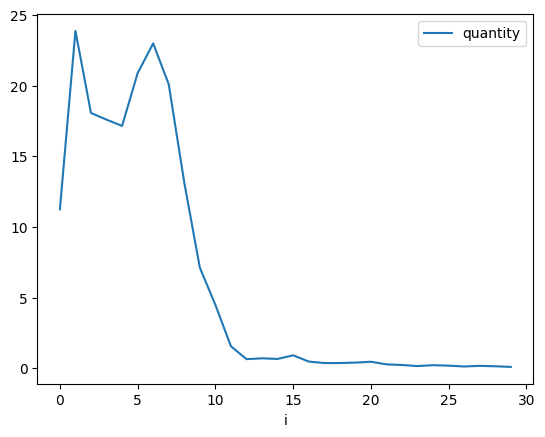

In [228]:
lamdaib.iloc[:30].plot()

In [207]:
first = pd.DataFrame(e.arrivals.buy, columns=['i', 'quantity']).groupby('i').mean()

In [208]:
second = pd.DataFrame(e.arrivals.sell , columns=['i', 'quantity']).groupby('i').mean()

In [215]:
msgs[0]

BinanceUpdateMessage(raw='1680788074.629167: {"stream":"ethusdt@aggTrade","data":{"e":"aggTrade","E":1680788074489,"s":"ETHUSDT","a":880496927,"p":"1864.10000000","q":"0.00570000","f":1123675678,"l":1123675678,"T":1680788074489,"m":false,"M":true}}\n', ts=datetime.datetime(2023, 4, 6, 13, 34, 34, 629167, tzinfo=datetime.timezone.utc), payload=BinanceTrade(stream='ethusdt@aggTrade', data=BinanceTradeData(event_type='aggTrade', ts=datetime.datetime(2023, 4, 6, 13, 34, 34, 489000, tzinfo=datetime.timezone.utc), symbol='ETHUSDT', agg_trade_id=880496927, price=Decimal('1864.10000000'), quantity=Decimal('0.00570000'), first_trade_id=1123675678, last_trade_id=1123675678, trade_time=datetime.datetime(2023, 4, 6, 13, 34, 34, 489000, tzinfo=datetime.timezone.utc), is_market_maker=False, is_ignore=True, side=None)))

In [209]:
first

,quantity
i,
0,15.814413
1,15.341537
2,14.777681
3,13.624776
4,12.837885
...,...
1991,0.14416
1992,0.106
1993,0.636


In [210]:
holder = pd.DataFrame(0, columns=['quantity'],
                               index=first.index.union(second.index))

In [214]:
((holder + first).fillna(0) + second).mean().iloc[0]

223.21099160233814

In [187]:

new = pd.DataFrame(0, columns=['quantity'],
                   index=first.index.union(second.index))

In [192]:
c Counter([i[0] for i in e.arrivals.buy])

Counter({1: 1566,
         6: 1508,
         5: 1370,
         7: 1318,
         2: 1185,
         3: 1154,
         4: 1125,
         8: 862,
         0: 738,
         9: 467,
         10: 294,
         11: 102,
         15: 60,
         1991: 50,
         13: 46,
         14: 43,
         12: 42,
         16: 31,
         50: 31,
         20: 30,
         41: 28,
         65: 27,
         19: 26,
         17: 24,
         18: 24,
         57: 23,
         305: 23,
         55: 22,
         51: 21,
         64: 21,
         42: 21,
         46: 21,
         54: 19,
         21: 18,
         73: 18,
         40: 18,
         47: 18,
         44: 17,
         63: 16,
         45: 16,
         43: 16,
         75: 15,
         48: 15,
         22: 15,
         49: 14,
         59: 14,
         52: 14,
         24: 14,
         53: 14,
         58: 13,
         67: 13,
         35: 13,
         66: 13,
         62: 12,
         25: 12,
         115: 12,
         74: 11,
         56: 11,
 

In [139]:
Sm = np.mean(e.market_arrivals.undefined)
Sl = (pd.DataFrame(e.arrivals.buy).groupby(0).mean() +
      pd.DataFrame(e.arrivals.sell).groupby(0).mean()).mean()

Sc = (pd.DataFrame(e.cancels.sell).groupby(0).mean() +
      pd.DataFrame(e.cancels.buy).groupby(0).mean())


In [153]:
# pd.DataFrame(e.cancels.sell).groupby(0).mean() 


In [135]:
np.mean(avgs)

Decimal('14.21694730961155265720172994')

In [138]:
pd.DataFrame(e.cancels.buy)

,0,1
0,3,1.20000000
1,1,0.07100000
2,1,28.27700000
3,4,1.57500000
4,1,9.00000000
...,...,...
14022,1,40.21000000
14023,2,84.67900000
14024,6,40.21000000
14025,1,14.62300000
